In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(500)
np.random.seed(500)

# same as before, defining the neural network and setting up the layers
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
           
        self.fc1= nn.Linear(1, 20) # Layer 1, 1 unput, 20 outputs
        self.fc2=nn.Linear(20, 20) # hidden layer
        self.fc3= nn.Linear(20, 1) # 1 output
        self.tanh=nn.Tanh() #activation function
        
# forward pass through the network, applying the activation function at each layer
    def forward(self, x):
        out=self.tanh(self.fc1(x))
        out=self.tanh(self.fc2(out))
        out=self.tanh(self.fc3(out))
        return x*(1-x)*out

# Define f(x) = -6x +3 (the exact solution is u(x) = x(x-1)(x-0.5))
def f(x):
    return -6 * x + 3

# Loss function
def pinn_loss(model, x_interior):
    
    x_interior.requires_grad_(True) # to avoid error when using torch.autograd
    u = model(x_interior) # predicted solution at interior points
    
    #computing the partial derivative of u wrt x_interior
    #grad_outputs is needed because u is not a scalar, needed for the right dimension
    #create graph allows you to calculate higher order derivatives later on
    #it returns a tuple even if only 1 input so use [0] to extract the gradient
    
    u_x = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    #computing second derivative same method as above
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    residual = -u_xx - f(x_interior) #require this to be zero to satisfy the PDE
    loss_pde = torch.mean(residual**2) #PDE loss is mean squared residual, aim for this to be close to zero, this is loss in interior

   

    return loss_pde 



# Model and optimizer
model = FCNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #using adam (extension of SGD, adj lr) with learning rate 1e-3
loss_history = [] #to plot loss function later

# Training loop
epochs = 5000 
for epoch in range(epochs):
    # Training data 
    N_interior = 100 
    x_interior = torch.rand(N_interior, 1) #sampling 100 points inside [0,1]
    x_boundary = torch.tensor([[0.0], [1.0]]) #boundary points at 0 and 1
    optimizer.zero_grad() #reset gradients before storing new ones so they dont accumulate
    loss = pinn_loss(model, x_interior)
    loss.backward() #backpropagation
    optimizer.step() #updating parameters
    loss_history.append(loss.item()) #putting loss values in list
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}") #printing the loss values every 500 epochs


Epoch 0, Loss: 4.09957
Epoch 500, Loss: 0.02620
Epoch 1000, Loss: 0.02033
Epoch 1500, Loss: 0.00073
Epoch 2000, Loss: 0.00021
Epoch 2500, Loss: 0.00010
Epoch 3000, Loss: 0.00010
Epoch 3500, Loss: 0.00007
Epoch 4000, Loss: 0.00004
Epoch 4500, Loss: 0.00003


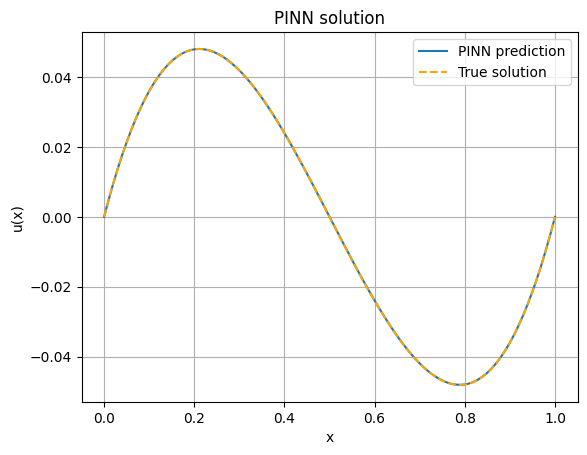

In [2]:
# Plot of the solution
x_plot = torch.linspace(0, 1, 100).reshape(-1, 1) #grid of 100 points between 0 and 1
u_pred = model(x_plot).detach().numpy() #evaluates trained model at the points, not using gradients anymore, convert to numpy

#plot the graph 
u_true = x_plot * ( x_plot-1)* (x_plot-0.5) #actual solution
plt.plot(x_plot, u_pred, label='PINN prediction')
plt.plot(x_plot, u_true, '--', label='True solution', color='orange')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN solution')
plt.legend()
plt.grid(True)
plt.savefig("cubic_pinns_plot.pdf")
plt.show()

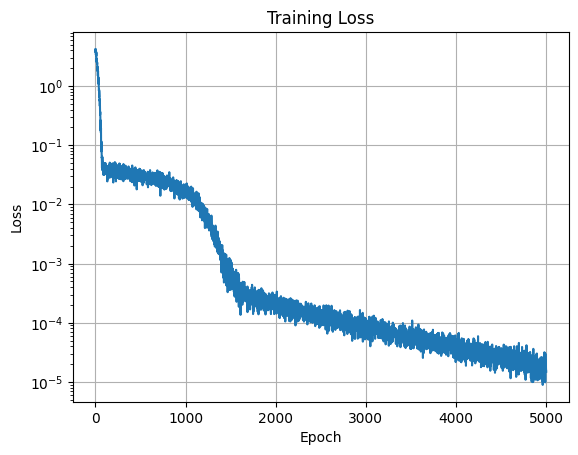

In [3]:
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig("cubic_pinns_loss.pdf")
plt.show()

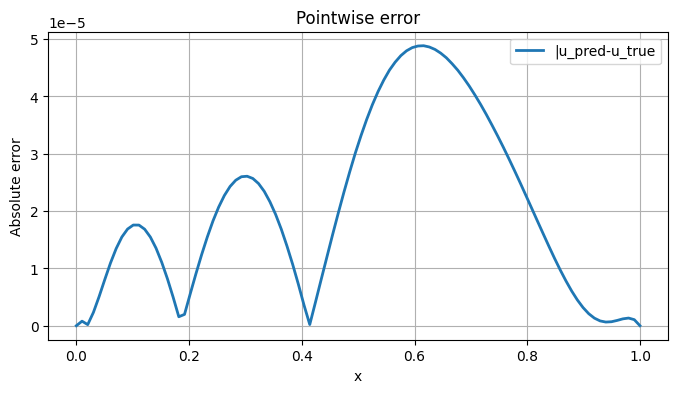

In [4]:
error=np.abs(u_pred-u_true.numpy())
plt.figure(figsize=(8,4))
plt.plot(x_plot, error, label='|u_pred-u_true', linewidth=2)

plt.xlabel("x")
plt.ylabel("Absolute error")
plt.title("Pointwise error")
plt.legend()
plt.grid(True)
plt.savefig("cubic_pinns_error.pdf")
plt.show()

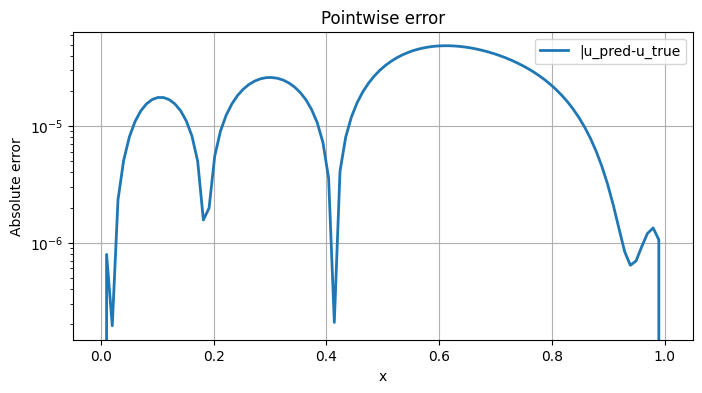

In [5]:
error=np.abs(u_pred-u_true.numpy())
plt.figure(figsize=(8,4))
plt.semilogy(x_plot, error, label='|u_pred-u_true', linewidth=2)

plt.xlabel("x")
plt.ylabel("Absolute error")
plt.title("Pointwise error")
plt.legend()
plt.grid(True)
plt.savefig("cubic_pinns_logerror.pdf")
plt.show()